In [6]:
import matplotlib.pyplot as plt
import numpy as np

from helperTools import *
from KevinBumperClass import swarmShift_x
from storageRingModeler import StorageRingModel,make_optimal_solution_model
from phaseSpaceAnalyzer import SwarmSnapShot
from phaseSpaceAnalysis_Functions import make_phase_space_info,plot_ring_lattice_with_stops,emittance_from_particles,get_emittances

from ParticleClass import Swarm
%matplotlib inline
model=make_optimal_solution_model()

/Users/williamdebenham/Desktop/storageRing/storageRing/storageRingModel/latticeModels/injectorModel_1.py:105: UserWarning: Need to add more here, this isn't right
  warnings.warn("Need to add more here, this isn't right")


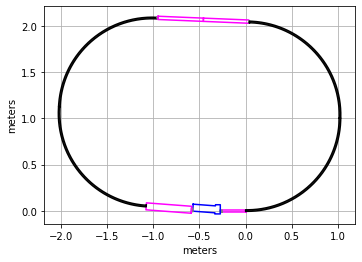

In [7]:
%matplotlib inline
model.lattice_ring.show_lattice()

In [ ]:
num_stops=10
start=model.lattice_ring.total_length/num_stops
stop=model.lattice_ring.total_length-start
x_stops_periodic=np.linspace(start,stop,num_stops)
T_max_sim=100.0
num_particles_sim=3000
t=time.time()
phase_space_info,phase_space_info_x_stops=make_phase_space_info(model,x_stops_periodic,-1,T_max_sim,num_particles_sim)
print(time.time()-t)

In [9]:
# model.lattice_ring.total_length
'a'

'a'

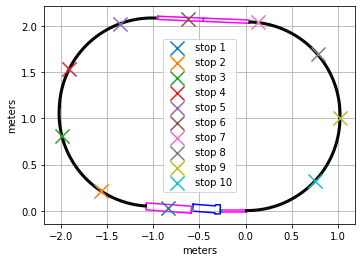

In [10]:
%matplotlib inline
plot_ring_lattice_with_stops(model,phase_space_info,savefig='lattice_with_stops',dpi=300)

In [70]:
from phaseSpaceAnalysis_Functions import make__is_valid_function
T_min=1.0
is_valid=make__is_valid_function(phase_space_info,T_min=T_min,clip_x_to_min_survived_dist=True)
x_vals=[]
epsy_vals,epsz_vals=[],[]
num_particles=[]
for i in range(len(phase_space_info[0])):
    for j in range(len(phase_space_info)):
        particles_valid = list(filter(is_valid, phase_space_info[j][i]))
        num_particles.append(len(particles_valid))
        if len(particles_valid)>0:
            epsy, epsz = emittance_from_particles(particles_valid)
            epsy_vals.append(epsy)
            epsz_vals.append(epsz)
            x_val=phase_space_info_x_stops[j][i]
            x_vals.append(x_val)

x_vals=x_vals[len(phase_space_info)-1:]
revolutions_vals=x_vals/model.lattice_ring.total_length
epsz_vals=epsz_vals[len(phase_space_info)-1:]
epsy_vals=epsy_vals[len(phase_space_info)-1:]

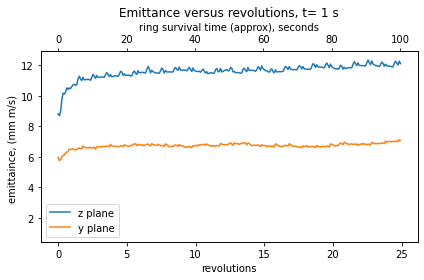

In [72]:
time_max=max(particle.T for particle in phase_space_info[0][0] if is_valid(particle))
times=np.linspace(0,time_max,len(revolutions_vals))
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax1.plot(revolutions_vals,epsz_vals,label='z plane')
ax1.plot(revolutions_vals,epsy_vals,label='y plane')
ax2.set_xlabel("ring survival time (approx), seconds")
ax2.plot(times,np.ones(len(revolutions_vals)),alpha=0.0)
ax1.set_ylabel("emittaince, (mm m/s) ")
ax1.set_xlabel('revolutions')
ax1.legend()
plt.title("Emittance versus revolutions, t= "+str(round(T_min))+ ' s')
plt.tight_layout()
plt.savefig('emittance_versus_time',dpi=200)
plt.show()

In [59]:
time

100.0091999855074

2064.929211805219


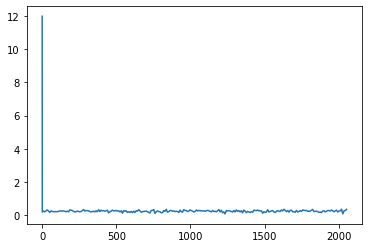

In [79]:
stop_index=8
T_min=T_max_sim
epsy_stops,epsz_stops, num_particles_stop=get_emittances(phase_space_info,stop_index,clip_x_to_min_survived_dist=True,T_min=T_min)
plt.plot(phase_space_info_x_stops[0],epsz_stops)
plt.show()

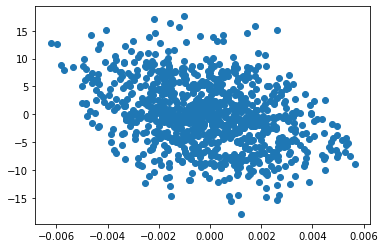

In [202]:
info=phase_space_info[0]
swarm=model.generate_Swarm(1000)
yi,pyi=[],[]
for particle in swarm:
    yi.append(particle.qi[1])
    pyi.append(particle.pi[1])
plt.scatter(yi,pyi)

plt.show()

# flux versus initial phase space of focus for random swarm

### Transverse dependence

In [158]:

import matplotlib.pyplot as plt
import numpy as np
from KevinBumperClass import swarmShift_x

from helperTools import *
from KevinBumperClass import swarmShift_x
from storageRingModeler import StorageRingModel,make_optimal_solution_model
from phaseSpaceAnalyzer import SwarmSnapShot
from phaseSpaceAnalysis_Functions import make_phase_space_info,plot_ring_lattice_with_stops,emittance_from_particles,get_emittances

# num=4
theta_max=2*5/100
p_r_max=theta_max*model.lattice_ring.speed_nominal
r_max=.02


def restricted_swarm(q_r,p_r,num_particles):
    return model.swarm_tracer_injector.initalize_pseudorandom_swarm_in_phase_space(q_r,p_r,1e-12,num_particles,same_seed=True)

swarm_custom=restricted_swarm(r_max,p_r_max,100_000)
swarm_custom=model.swarm_tracer_injector.time_step_swarm_distance_along_x(swarm_custom, swarmShift_x,
                                                                    hold_position_in_x=True)
model.swarm_injector_initial=swarm_custom
traced_swarm=model.inject_swarm(parallel=True)

In [159]:
norm=np.linalg.norm
num=10
q_radii=np.linspace(r_max/20.0,r_max,num)
p_radii=np.linspace(p_r_max/20.0,p_r_max,num)
def valid_particles(r_cutoff,p_r_cutoff):
    is_valid=lambda part: norm(part.pi[1:])<p_r_cutoff and norm(part.qi[1:])<r_cutoff
    particles_valid=[traced_swarm.particles[i] for i,particle in enumerate(swarm_custom) if is_valid(particle)]
    return particles_valid
def characterize(r_cutoff,p_r_cutoff):
    particles_valid=valid_particles(r_cutoff,p_r_cutoff)
    num_particles=len(particles_valid)
    if len(particles_valid)==0.0:
        return np.nan,num_particles
    else:
        revs=sum([particle.revolutions for particle in particles_valid])
        return revs,num_particles
def flux_multiplication(r_cutoff,p_r_cutoff):
    revs,num_particles=characterize(r_cutoff,p_r_cutoff)
    if num_particles==0:
        return np.nan
    else:
        return revs/num_particles
def flux(r_cutoff,p_r_cutoff):
    revs,_=characterize(r_cutoff,p_r_cutoff)
    return revs
args=arr_product(q_radii,p_radii)
image_mult, extent=make_image_cartesian(flux_multiplication,q_radii,p_radii)
image_flux, _=make_image_cartesian(flux,q_radii,p_radii)
extent[0]*=1000
extent[1]*=1000

looping over function inputs to make image data
looping over function inputs to make image data


In [160]:
time_one_rev=model.lattice_ring.total_length/model.lattice_ring.speed_nominal
max_flux_mult_possible=model.T/time_one_rev
max_flux_possible=max_flux_mult_possible*len(swarm_custom)

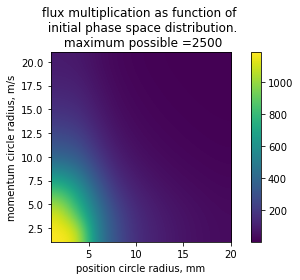

[1.0, 20.0, 1.05, 21.0]

In [163]:
%matplotlib inline
plt.imshow(image_mult,extent=extent,interpolation='bicubic')
plt.title("flux multiplication as function of \n initial phase space distribution.\n maximum possible =2500")
plt.colorbar()
plt.xlabel("position circle radius, mm")
plt.ylabel("momentum circle radius, m/s")
plt.tight_layout()
plt.savefig("flux_multiplication",dpi=200,bbox_inches='tight')
plt.show()
extent

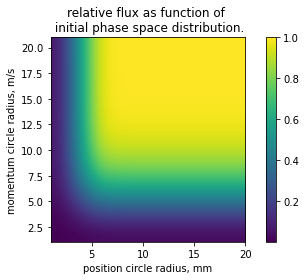

In [164]:
# %matploti
plt.imshow(image_flux/np.nanmax(image_flux),extent=extent,interpolation='bicubic')
plt.title("relative flux as function of \n initial phase space distribution.")
plt.colorbar()
plt.xlabel("position circle radius, mm")
plt.ylabel("momentum circle radius, m/s")
plt.tight_layout()
plt.savefig("flux_multiplication",dpi=200,bbox_inches='tight')
plt.show()

### longitudinal dependence

In [73]:
swarm_custom=Swarm()
px_vals=np.linspace(-100,-300,1_000)
for px in px_vals:
    swarm_custom.add_new_particle(pi=np.array([px,0.0,0.0]))
swarm_custom=model.swarm_tracer_injector.time_step_swarm_distance_along_x(swarm_custom, swarmShift_x,
                                                                          hold_position_in_x=True)
model.swarm_injector_initial=swarm_custom
traced_swarm=model.inject_swarm(parallel=True)

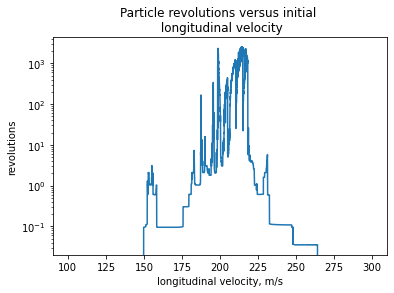

In [183]:
revs=np.array([particle.revolutions for particle in traced_swarm])
revs_max=model.T/time_one_rev
plt.title("Particle revolutions versus initial \n longitudinal velocity")
plt.semilogy(np.abs(px_vals),revs)
plt.ylabel("revolutions")
plt.xlabel("longitudinal velocity, m/s")
plt.savefig("long")
plt.show()